# News Sentiment Analysis

## Import Libraries

In [1]:
# // TODO: TINGS
#     ✓ Find API for data collection
#     ✓ Data Gathering
#     ✓ Data Cleaning
#     - Feature generation
#     - Feature Engineering/selection
#     - Model Train
#     - Model Test
#     - Model Evaluation

In [2]:
# Common Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob
import re
from IPython.display import clear_output
import time
import random

# Cleaner output
from tqdm import tqdm

# Deep Learning Libraries
import torch

# Add the path to the API Scraper
## Project Path
project_path = "../"

## Add the path to API Scraper
sys.path.append(os.path.abspath(os.path.join(project_path, "lib")))

# Custom News Libraries
from scraper import get_cached_news_metadata, extract_text_from_url

# Text preprocessing
from preprocessor import clean_text

## Fetch Data

In [3]:
def scrape_data(n_request: int = 10, before_date: str = "2025-12", path: str = ".", last_idx:int = 0) -> pd.DataFrame:
    
    articles = []

    for i in tqdm(range(last_idx, last_idx + n_request), desc="Fetching News Data...", unit="news"):
        metadata = get_cached_news_metadata(page=i, before_date=before_date, path=path)

        data_list = metadata.get("data", [])

        for article in data_list:
            # extract sentiment (first entity if exists)
            entities = article.get("entities", [])
            if entities and "sentiment_score" in entities[0]:
                sentiment = entities[0]["sentiment_score"]
            else:
                sentiment = None

            # store sentiment as its own field inside article
            article["sentiment"] = sentiment

            articles.append(article)

    # final dataframe
    return pd.DataFrame(articles)

### Caching

In [4]:
# Arguments for the caching function
before_date = "2025-11"

data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
os.makedirs(data_path, exist_ok=True) # if the directory exist no need to make

cached_file = os.path.join(data_path, f"{before_date}_news_data.csv")

# Set this to TRUE if you want to get new data/overwrite the old data
overwrite_cached_links = False

# get the last index of the file 
json_files = os.path.join(project_path, f"news_cache/{before_date}/json/page-*.json")
list_of_files = glob.glob(json_files)

## Extract page numbers set to True if you want to get new api request.
get_new_requests = False

if get_new_requests:
    page_nums = []
    for f in list_of_files:
        match = re.search(r"page-(\d+)\.json$", os.path.basename(f))
        if match:
            page_nums.append(int(match.group(1)))

    last_idx = max(page_nums)
    n_requests = 101 # marketaux api limit (last index is excluded)

else:
    last_idx = 0
    n_requests = len(list_of_files) #number of pages we cached to be processed

In [5]:
# filling missing text data function

def safe_extract(row):
    try:
        text = extract_text_from_url(row["url"])
        # print(f"{row['title']} {row['description']}")
        return text

    except Exception as e:
        tqdm.write(f"failed to extract from url \n Err: {e} \n appending title and description")
        time.sleep(2)
        print(f"{row['title']} {row['description']}")
        clear_output(wait=True)
        text = f"{row['title']} {row['description']}"
        return text

In [6]:
# tqdm for cleaner output
tqdm.pandas(desc="Extracting News from URL's", unit="news")

# We will cache the data so that it will load faster
if os.path.exists(cached_file) and not overwrite_cached_links:
    print("Loading cached dataset...")
    news_df = pd.read_csv(cached_file, sep = ',')
    print("Cached dataset loaded")

elif os.path.exists(cached_file) and overwrite_cached_links:
    print("Overwriting old data and caching new data...")
    # Scrape the data
    news_df = scrape_data(n_request=n_requests, before_date= before_date, path= project_path, last_idx=last_idx)
    
    # Extract text from the news
    news_df["text"] = news_df.progress_apply(safe_extract, axis=1)
    news_df.to_csv(cached_file, index=False)
    print("Done Overwriting old data and caching new data...")

else:
    print("Creating and caching dataset...")
    news_df = scrape_data(n_request=n_requests, before_date= before_date, path= project_path, last_idx=last_idx)
    news_df["text"] = news_df.progress_apply(safe_extract, axis=1)
    news_df.to_csv(cached_file, index=False)
    print("Finished Caching")

Loading cached dataset...
Cached dataset loaded


### Fetch the Text from URL

## EDA

### View the Data

In [7]:
news_df.head(10)

,uuid,title,description,keywords,snippet,url,image_url,language,published_at,source,relevance_score,entities,similar,sentiment,text
0,487e6a88-d3c2-4ae1-8dc2-26af6b31d688,2025: The Year Of Alphabet (GOOG),No stock has seen a bigger jump recently than ...,NaN,vzphotos/iStock Editorial via Getty Images\n\n...,https://seekingalpha.com/article/4848680-2025-...,https://static.seekingalpha.com/cdn/s3/uploads...,en,2025-11-30T05:30:00.000000Z,seekingalpha.com,NaN,"[{'symbol': 'GOOGL', 'name': 'Alphabet Inc.', ...",[],0.0000,NaN
1,92b5c2bd-d324-4ae8-b115-2cfd95a8fa98,Why I'm Doubling Down On My Adobe Position (NA...,"Adobe's revenue is highly predictable, driven ...",NaN,To say that Adobe ( ADBE ) stock has not had a...,https://seekingalpha.com/article/4848762-why-i...,https://static.seekingalpha.com/cdn/s3/uploads...,en,2025-11-30T05:25:01.000000Z,seekingalpha.com,NaN,"[{'symbol': 'ADBE', 'name': 'Adobe Inc.', 'exc...",[],0.0000,NaN
2,9084e5f1-75f5-4f15-aa3d-0676073b4aaf,Global week ahead: The start of a Santa Rally ...,NaN,"STOXX 600, business news",And just like that... December is upon us. It'...,https://www.cnbc.com/2025/11/30/global-week-ah...,https://image.cnbcfm.com/api/v1/image/10823257...,en,2025-11-30T05:10:58.000000Z,cnbc.com,NaN,"[{'symbol': 'M', 'name': ""Macy's, Inc."", 'exch...",[],0.6908,And just like that... December is upon us. It'...
3,487e6a88-d3c2-4ae1-8dc2-26af6b31d688,2025: The Year Of Alphabet (GOOG),No stock has seen a bigger jump recently than ...,NaN,vzphotos/iStock Editorial via Getty Images\n\n...,https://seekingalpha.com/article/4848680-2025-...,https://static.seekingalpha.com/cdn/s3/uploads...,en,2025-11-30T05:30:00.000000Z,seekingalpha.com,NaN,"[{'symbol': 'GOOGL', 'name': 'Alphabet Inc.', ...",[],0.0000,NaN
4,92b5c2bd-d324-4ae8-b115-2cfd95a8fa98,Why I'm Doubling Down On My Adobe Position (NA...,"Adobe's revenue is highly predictable, driven ...",NaN,To say that Adobe ( ADBE ) stock has not had a...,https://seekingalpha.com/article/4848762-why-i...,https://static.seekingalpha.com/cdn/s3/uploads...,en,2025-11-30T05:25:01.000000Z,seekingalpha.com,NaN,"[{'symbol': 'ADBE', 'name': 'Adobe Inc.', 'exc...",[],0.0000,NaN
5,9084e5f1-75f5-4f15-aa3d-0676073b4aaf,Global week ahead: The start of a Santa Rally ...,NaN,"STOXX 600, business news",And just like that... December is upon us. It'...,https://www.cnbc.com/2025/11/30/global-week-ah...,https://image.cnbcfm.com/api/v1/image/10823257...,en,2025-11-30T05:10:58.000000Z,cnbc.com,NaN,"[{'symbol': 'M', 'name': ""Macy's, Inc."", 'exch...",[],0.6908,And just like that... December is upon us. It'...
6,7d36a275-f3a3-44ea-8cbc-caa0d67749c4,Global Risk Monitor: Week in Review – Nov 28,KEY ISSUES Silver surged 13% for the week and ...,NaN,KEY ISSUES\n\nSilver surged 13% for the week a...,https://global-macro-monitor.com/2025/11/29/gl...,https://global-macro-monitor.com/wp-content/up...,en,2025-11-30T05:07:50.000000Z,global-macro-monitor.com,NaN,"[{'symbol': 'NVDA', 'name': 'NVIDIA Corporatio...",[],-0.3612,KEY ISSUES\n\nSilver surged 13% for the week a...
7,42ba634c-b7ce-491a-91c0-e2b1424af827,"Mcap boost: 7 of top-10 firms gain ₹96,201 cr;...",Market valuations of seven top firms rose by ₹...,NaN,The combined market valuation of seven of the ...,https://www.thehindubusinessline.com/markets/m...,https://bl-i.thgim.com/public/incoming/ji6cih/...,en,2025-11-30T05:04:20.000000Z,thehindubusinessline.com,NaN,"[{'symbol': 'SBKFF', 'name': 'State Bank of In...",[],0.0000,The combined market valuation of seven of the ...
8,47000f09-22ab-4309-9411-c0c738327c25,QQQX: Tax-Efficient Dividends From The Nasdaq-...,Discover why Nuveen NASDAQ 100 Dynamic Overwri...,NaN,"With the rise of covered call ETFs, it can be ...",https://seekingalpha.com/article/4848757-qqqx-...,https://static.seekingalpha.com/cdn/s3/uploads...,en,2025-11-30T04:23:00.000000Z,seekingalpha.com,NaN,"[{'symbol': 'QQQX', 'name': 'Nuveen Nasdaq 100...",[],0.3715,NaN
9,927ce408-c559-4f17-b673-37b0e9e301d7,Wall Street pred

### Check for Missing Values

In [8]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0            0.000000
title                         0            0.000000
description                 298            4.527499
keywords                   3357           51.002735
snippet                      26            0.395017
url                           0            0.000000
image_url                    21            0.319052
language                      0            0.000000
published_at                  0            0.000000
source                        0            0.000000
relevance_score            6582          100.000000
entities                      0            0.000000
similar                       0            0.000000
sentiment                     0            0.000000
text                       2402           36.493467


### Distribution of the Sentiment Scores

#### Plotting Functions

In [9]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

#### Data Plots (Before Cleaning)

##### Sentiment Score Distribution

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/text_mining_research-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

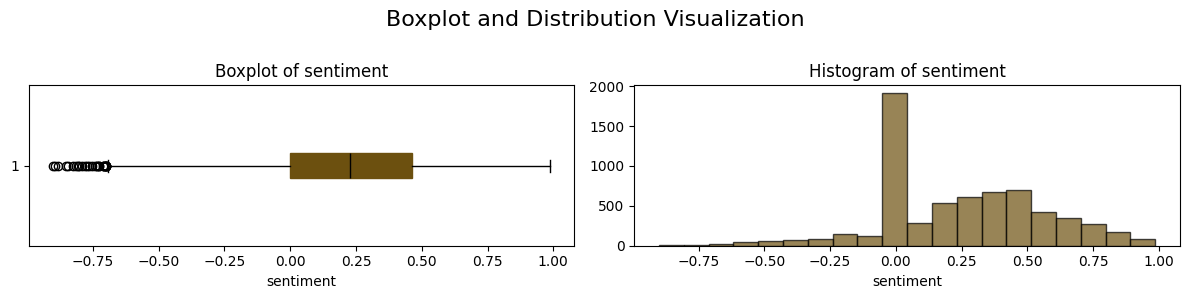

In [10]:
numeric_dist_plot(pd.DataFrame(news_df["sentiment"]))

##### Word Count Distribution

<Axes: title={'center': 'Text_Length Distribution'}, xlabel='length', ylabel='Count'>

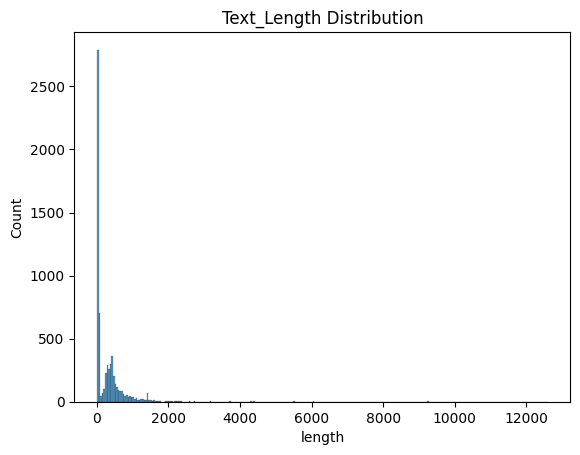

In [11]:
news_df['text'] = news_df['text'].apply(str)
news_df['length'] = news_df['text'].str.split().apply(len)
plt.title("Text_Length Distribution")
sns.histplot(news_df['length'])

In [12]:
news_df['length'].describe()

count     6582.000000
mean       325.748101
std        735.000401
min          1.000000
25%          1.000000
50%         89.000000
75%        424.000000
max      12606.000000
Name: length, dtype: float64

## Data Cleaning

### Fix Missing Values

In [13]:
news_df["text"] = news_df["text"].replace("", None)

In [14]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0            0.000000
title                         0            0.000000
description                 298            4.527499
keywords                   3357           51.002735
snippet                      26            0.395017
url                           0            0.000000
image_url                    21            0.319052
language                      0            0.000000
published_at                  0            0.000000
source                        0            0.000000
relevance_score            6582          100.000000
entities                      0            0.000000
similar                       0            0.000000
sentiment                     0            0.000000
text                          0            0.000000
length                        0            0.000000


In [15]:
# Fill the missing text from the url with just the news description. due to the scraper is unable to get the html since the site requires authorization
news_df["text"] = news_df["text"].fillna(
    news_df["title"].fillna('') + " " + news_df["description"].fillna('')
)

In [16]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0            0.000000
title                         0            0.000000
description                 298            4.527499
keywords                   3357           51.002735
snippet                      26            0.395017
url                           0            0.000000
image_url                    21            0.319052
language                      0            0.000000
published_at                  0            0.000000
source                        0            0.000000
relevance_score            6582          100.000000
entities                      0            0.000000
similar                       0            0.000000
sentiment                     0            0.000000
text                          0            0.000000
length                        0            0.000000


### Drop Duplicated Data

In [17]:
news_df.duplicated().sum()

np.int64(215)

In [18]:
news_df = news_df.drop_duplicates()

In [19]:
news_df.duplicated().sum()

np.int64(0)

### Clean the Text

In [20]:
# Arguments for the caching function
cleaned_data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
os.makedirs(cleaned_data_path, exist_ok=True) # if the directory exist no need to make

clean_cached_file = os.path.join(cleaned_data_path, f"{before_date}_clean_news_data.csv")

# Set this to TRUE if you want to get new data/overwrite the old data
overwrite_clean_data = True

In [21]:
# tqdm for cleaner output
tqdm.pandas(desc="Cleaning the Text", unit="news")

# We will cache the data so that it will load faster
if os.path.exists(clean_cached_file) and not overwrite_clean_data:
    print("Loading cached dataset...")
    news_df = pd.read_csv(clean_cached_file)
    print("Cached dataset loaded")

elif os.path.exists(clean_cached_file) and overwrite_clean_data:
    print("Overwriting old data and caching new data...")
    # Clean the data
    news_df["clean_text"] = news_df["text"].progress_apply(
                                                        lambda x: clean_text(
                                                            text = x,
                                                            tokenize=False,
                                                            remove_stop_words= True,
                                                            remove_emojis="keep"
                                                            )
                                                        )
    news_df.to_csv(clean_cached_file, index=False)
    print("Done Overwriting old data and caching new data...")

else:
    print("Creating and caching dataset...")
    # Clean the data
    news_df["clean_text"] = news_df["text"].progress_apply(
                                                        lambda x: clean_text(
                                                            text = x,
                                                            tokenize=False,
                                                            remove_stop_words= True,
                                                            remove_emojis="keep"
                                                            )
                                                        )
    news_df.to_csv(clean_cached_file, index=False)
    print("Finished Caching")

Overwriting old data and caching new data...


Cleaning the Text: 100%|██████████| 6367/6367 [00:03<00:00, 1894.78news/s]


Done Overwriting old data and caching new data...


##### Sentiment Score Distribution (After Cleaning)

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/text_mining_research-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

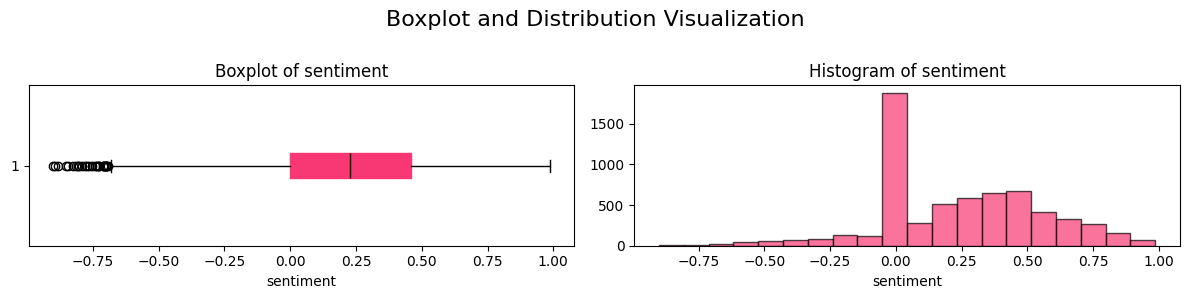

In [22]:
numeric_dist_plot(pd.DataFrame(news_df["sentiment"]))

##### Word Count Distribution

<Axes: title={'center': 'Text_Length Distribution'}, xlabel='length', ylabel='Count'>

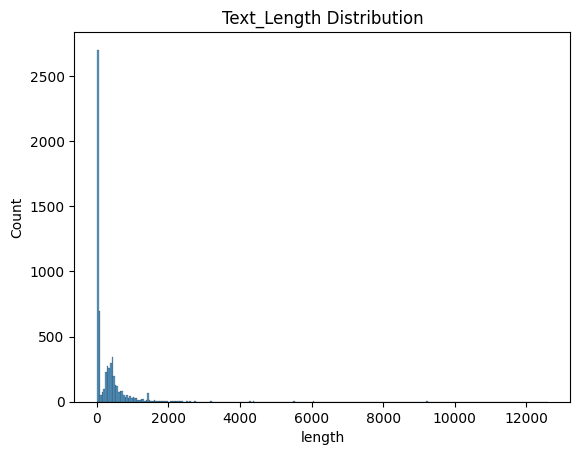

In [23]:
news_df['text'] = news_df['text'].apply(str)
news_df['length'] = news_df['text'].str.split().apply(len)
plt.title("Text_Length Distribution")
sns.histplot(news_df['length'])

In [24]:
news_df['length'].describe()

count     6367.000000
mean       323.853306
std        739.416798
min          1.000000
25%          1.000000
50%         89.000000
75%        422.000000
max      12606.000000
Name: length, dtype: float64